In [1]:
import os

fname = os.path.join('artifacts','jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(",")
lines = lines[1:]
print(header) # Features of the dataset
print(len(lines)) # Number of records in the dataset


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv(fname)
df.head()

C:\Users\arany\AppData\Local\Temp\ipykernel_8456\2899765279.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
# Extracting the temperature data and all data into seperate array(after removing the date time column)
temperature = df['T (degC)'] 
raw_data = df.drop('Date Time',axis=1)


In [4]:
# Converting them into numpy arrays
temperature = temperature.to_numpy()
raw_data = raw_data.to_numpy()

In [5]:
import matplotlib.pyplot as plt

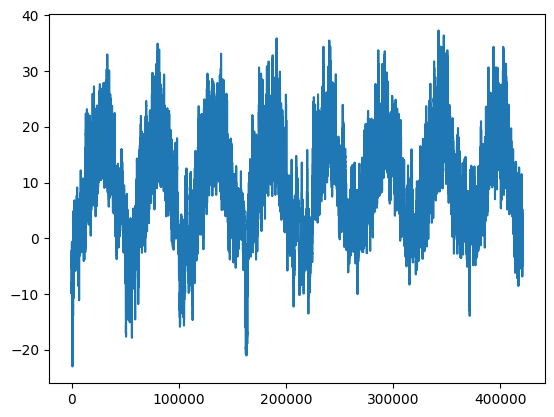

In [6]:
# Plot of temperature data over time (or over the dataset)
plt.plot(range(len(temperature)),temperature)

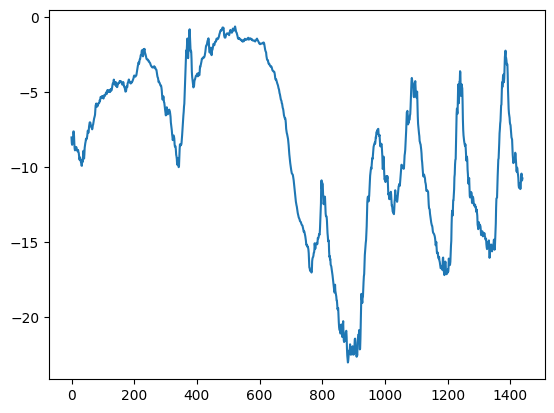

In [7]:
# Top 1440 records of temperature distribution over time
plt.plot(range(1440),temperature[:1440])

In [8]:
# When working with time series data , we are trying to predict the future values. So , its better to use validation and test data from time periods that happen in future wrt the training data

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data)) 
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# 50% - train data , 25 % validation data , 25% test data

In [10]:
# Normalizing the entire dataset based on the mean and standard deviation of the training data(since each feature has different scales)
# Can also be done using Standard Scaler
mean = raw_data[:num_train_samples].mean(axis=0)
std = raw_data[:num_val_samples].std(axis=0)

raw_data = (raw_data-mean) / std

In [11]:
len(raw_data)

420551

In [12]:
# timeseries_dataset_from_array() --> Used to generate batches of data using the numpy array and sequence or batch length( different than batching)
# [1,2,3,4,5,6,7,8,9] with sequence length 3 will fetch --> [1,2,3],[2,3,4],[3,4,5] ....
# targets argument will generate the next value of the sequence
# [1,2,3] -> 4
# [2,3,4] -> 5
# [3,4,5] -> 6 ... 

In [13]:
import tensorflow as tf
import keras

In [14]:
# Creating the datasets

sampling_rate = 6 # Out of 6, only 1 data point will be taken
sequence_length = 120 # Previous 5 days data will be taken into account for predicting the new data points
delay = sampling_rate * (sequence_length + 24 - 1) # Target of the sequence will be temperature 24 hours after the end of sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=0,
    end_index = num_train_samples
)

validation_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=num_train_samples + num_val_samples
)


In [15]:
# Common sense baseline MAE ( Since the temperature usually doesn't change between 24 hours, so a common baseline test could be that the temperature 24 hours from now equals to the current temperature)

In [16]:
def evaluate_naive_method(dataset):
    total_abs_error = 0
    samples_seen = 0
    for samples,targets in dataset:
        preds = samples[:,-1,1] * std[1] + mean[1] # Unnormalizing the inputs till the last temperature measurement in the input sequence( temperature feature is column 1)
        total_abs_error += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_error / samples_seen

print(f"Validation MAE : {evaluate_naive_method(validation_dataset):.2f}")
print(f"Test MAE : {evaluate_naive_method(test_dataset):.2f}")

Validation MAE : 2.44
Test MAE : 2.62


In [18]:
from keras.layers import Input , Dense , Flatten 
from keras.models import Model

In [19]:
from keras.callbacks import ModelCheckpoint

In [20]:
# Now trying a common basic machine learning model

# Regression model

input_layer = Input(shape=(sequence_length,raw_data.shape[-1]))

flatten_layer1 = Flatten()(input_layer)
dense_layer1 = Dense(16,activation="relu")(flatten_layer1)

output_layer = Dense(1)(dense_layer1)

model1 = Model(inputs=input_layer,outputs=output_layer)

callback_list = [
    ModelCheckpoint(filepath="timeseries_dense.keras",save_best_only=True)
]

model1.compile(optimizer="rmsprop",loss="mse",metrics="mae")

history1 = model1.fit(train_dataset,epochs=10,validation_data=validation_dataset,callbacks=callback_list)
history1

Epoch 1/10
819/819 [==============================] - 13s 12ms/step - loss: 2.5630 - mae: 2.5630 - val_loss: 2.5292 - val_mae: 2.5292
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 2.1630 - mae: 2.1630 - val_loss: 2.5557 - val_mae: 2.5557
Epoch 3/10
819/819 [==============================] - 11s 13ms/step - loss: 2.0804 - mae: 2.0804 - val_loss: 2.5653 - val_mae: 2.5653
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 2.0268 - mae: 2.0268 - val_loss: 2.6031 - val_mae: 2.6031
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 1.9910 - mae: 1.9910 - val_loss: 2.5739 - val_mae: 2.5739
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 1.9598 - mae: 1.9598 - val_loss: 2.6238 - val_mae: 2.6238
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 1.9467 - mae: 1.9467 - val_loss: 2.5919 - val_mae: 2.5919
Epoch 8/10
819/819 [==============================] - 9s 11ms/step 

In [21]:
model1.evaluate(test_dataset)[1]

405/405 [==============================] - 3s 7ms/step - loss: 13.3919 - mae: 13.3919


13.39192008972168

In [23]:
history1_dict = history1.history

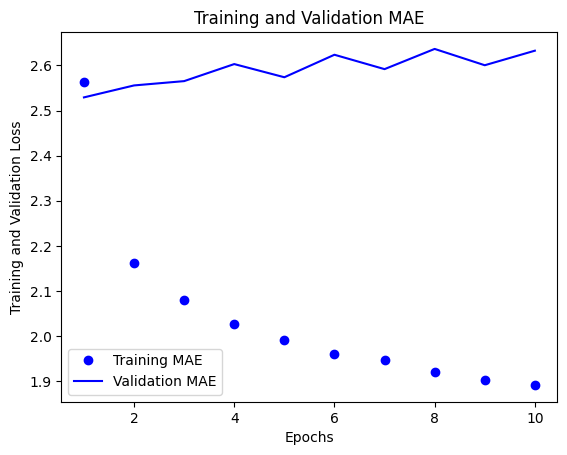

In [24]:
import matplotlib.pyplot as plt

num_epochs = range(1,len(history1_dict["loss"])+1)

plt.plot(num_epochs,history1_dict["loss"],"bo",label="Training MAE")
plt.plot(num_epochs,history1_dict["val_loss"],"b",label="Validation MAE")
plt.title("Training and Validation MAE for Dense Model")
plt.xlabel("Epochs")
plt.ylabel("Training and Validation Loss")
plt.legend()
plt.show()

In [29]:
from keras.layers import Conv1D
from keras.layers import MaxPool1D , GlobalAveragePooling1D

In [30]:
# 1D convolution layer

input_layer = Input(shape=(sequence_length,raw_data.shape[-1]))

conv_layer1 = Conv1D(8,24,activation="relu")(input_layer) # 24 is taken to consider 24 hour windows
max_pool1 = MaxPool1D(2)(conv_layer1)

conv_layer2 = Conv1D(8,12,activation="relu")(max_pool1)
max_pool2 = MaxPool1D(2)(conv_layer2)

conv_layer3 = Conv1D(8,6,activation="relu")(max_pool2)
global_pool = GlobalAveragePooling1D()(conv_layer3)

output_layer = Dense(1)(global_pool)

model2 = Model(inputs=input_layer,outputs=output_layer)

callback_list = [
    ModelCheckpoint(filepath="timeseries_conv1d.keras",save_best_only=True)
]

model2.compile(optimizer="rmsprop",loss="mse",metrics="mae")

history2 = model2.fit(train_dataset,epochs=10,validation_data=validation_dataset,callbacks=callback_list)
history2

Epoch 1/10
819/819 [==============================] - 22s 17ms/step - loss: 22.2899 - mae: 3.6921 - val_loss: 15.4779 - val_mae: 3.1436
Epoch 2/10
819/819 [==============================] - 13s 15ms/step - loss: 14.9154 - mae: 3.0747 - val_loss: 14.7038 - val_mae: 3.0314
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 13.5118 - mae: 2.9178 - val_loss: 17.5206 - val_mae: 3.2956
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 12.6111 - mae: 2.8168 - val_loss: 14.4394 - val_mae: 2.9706
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 12.0271 - mae: 2.7503 - val_loss: 15.0379 - val_mae: 3.0528
Epoch 6/10
819/819 [==============================] - 12s 14ms/step - loss: 11.5220 - mae: 2.6933 - val_loss: 14.3594 - val_mae: 2.9758
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 11.0790 - mae: 2.6387 - val_loss: 15.4994 - val_mae: 3.1115
Epoch 8/10
819/819 [============================

In [31]:
history2_dict = history2.history

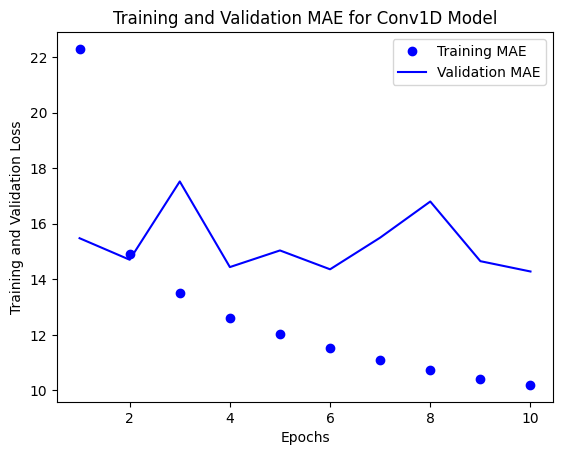

In [32]:
num_epochs = range(1,len(history2_dict["loss"])+1)

plt.plot(num_epochs,history2_dict["loss"],"bo",label="Training MAE")
plt.plot(num_epochs,history2_dict["val_loss"],"b",label="Validation MAE")
plt.title("Training and Validation MAE for Conv1D Model")
plt.xlabel("Epochs")
plt.ylabel("Training and Validation Loss")
plt.legend()
plt.show()

In [33]:
from keras.layers import LSTM

In [34]:
# LSTM Model 

input_layer = Input(shape=(sequence_length,raw_data.shape[-1]))

lstm_layer = LSTM(16)(input_layer)
output_layer = Dense(1)(lstm_layer)

model3 = Model(input_layer,output_layer)

model3.compile(optimizer="rmsprop",loss="mse",metrics="mae")

callback_list = [
    ModelCheckpoint(filepath="timeseries_lstm.keras",save_best_only=True)
]

history3 = model3.fit(train_dataset,epochs=10,validation_data=validation_dataset,callbacks=callback_list)
history3

Epoch 1/10
819/819 [==============================] - 33s 27ms/step - loss: 42.8821 - mae: 4.7720 - val_loss: 12.8340 - val_mae: 2.7215
Epoch 2/10
819/819 [==============================] - 22s 26ms/step - loss: 10.9334 - mae: 2.5735 - val_loss: 9.6106 - val_mae: 2.4122
Epoch 3/10
819/819 [==============================] - 20s 25ms/step - loss: 9.7879 - mae: 2.4436 - val_loss: 9.5279 - val_mae: 2.4046
Epoch 4/10
819/819 [==============================] - 20s 25ms/step - loss: 9.4438 - mae: 2.3930 - val_loss: 9.5188 - val_mae: 2.3918
Epoch 5/10
819/819 [==============================] - 20s 25ms/step - loss: 9.1670 - mae: 2.3518 - val_loss: 9.7638 - val_mae: 2.4210
Epoch 6/10
819/819 [==============================] - 20s 24ms/step - loss: 8.8747 - mae: 2.3139 - val_loss: 9.7934 - val_mae: 2.4219
Epoch 7/10
819/819 [==============================] - 20s 24ms/step - loss: 8.6306 - mae: 2.2838 - val_loss: 9.8394 - val_mae: 2.4305
Epoch 8/10
819/819 [==============================] - 20s 2

In [35]:
history3_dict = history3.history

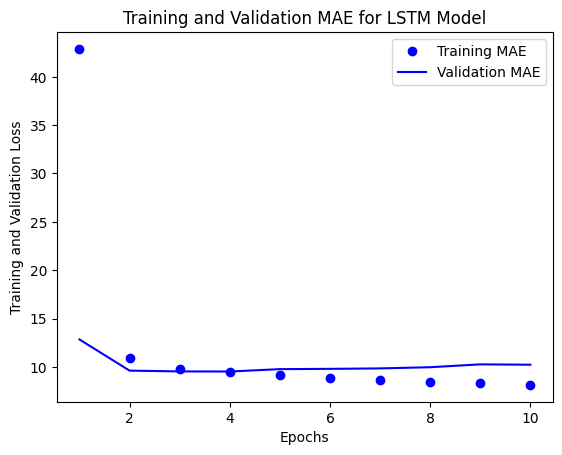

In [36]:
num_epochs = range(1,len(history3_dict["loss"])+1)

plt.plot(num_epochs,history3_dict["loss"],"bo",label="Training MAE")
plt.plot(num_epochs,history3_dict["val_loss"],"b",label="Validation MAE")
plt.title("Training and Validation MAE for LSTM Model")
plt.xlabel("Epochs")
plt.ylabel("Training and Validation Loss")
plt.legend()
plt.show()

In [37]:
# LSTM Model performing the best out of of the 3 models